# HMM Views IC Frontier: Oldest Country ETFs

## 1. Data Fetching

### 1.1 Model configuration

In [1]:
import os
import sys
import datetime as dt
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
import cvxportfolio as cp
import alphamodel as am

config = {'name': 'bl_hmm_sim',
          'universe':
              {'list': ['SPY', 'EWA', 'EWC', 'EWG', 'EWH', 'EWJ', 'EWS', 'EWU', 'EWW'],
               'ticker_col': 'Symbol',
               'risk_free_symbol': 'USDOLLAR'},
          'data':
              {'name': 'eod_returns',
               'source': 'quandl',
               'table': 'EOD',
               'api_key': "6XyApK2BBj_MraQg2TMD"},
          'model':
              {'start_date': '19970102',
               'end_date': '20011231',
               'halflife': 20,
               'min_periods': 3,
               'hidden_states': 2,
               'train_len': 750,
               'data_dir': '/Users/razvan/PyRepo/research_masc/data_store/hmm/',
               'returns':
                   {'sampling_freq': 'daily'},
               'covariance':
                    {'method' : 'FF5',
                     'sampling_freq' : 'monthly',
                     'train_days': 90}
              }
         }

/Users/razvan/miniconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


### 1.2 Fetch return data

In [3]:
# Fetch returns / volumes
ss = am.SingleStockHMM(config)
ss.train(force=True)

downloading SPY from 19970102 to 20011231
downloading EWA from 19970102 to 20011231
downloading EWC from 19970102 to 20011231
downloading EWG from 19970102 to 20011231
downloading EWH from 19970102 to 20011231
downloading EWJ from 19970102 to 20011231
downloading EWS from 19970102 to 20011231
downloading EWU from 19970102 to 20011231
downloading EWW from 19970102 to 20011231
downloading USDOLLAR from 19970102 to 20011231
Removing these days from dataset:
            nan price  nan open price  nan close price  nan volumes
1999-04-02          9             NaN              NaN          NaN
2001-09-13          9             NaN              NaN          NaN
2001-09-14          9             NaN              NaN          NaN
          remaining nan price  remaining nan open price  \
SPY                         0                         0   
EWA                         0                         0   
EWC                         0                         0   
EWG                         0    

True

## 2. HMM information coefficient frontier

Hyperparameters:
- hmm_mode: return prediction, 'e' (expectation), 't' (regime over probability threshold)
- preprocess: raw data or exponential decay
- train_len: length of training data
- halflife: halflife of exponential decay

In [ ]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

ic_vs_params = {}

for hmm_mode in ['e', 't']:
    for preprocess in [None, 'exponential']:
        for train_len in range(50, 1501, 50):
            for halflife in [65, 130, 250, 500, 750]:
                # Avoid cases we don't want to run
                if (not preprocess and halflife > 65) or train_len < halflife:
                    continue
                
                # Set the parameters for the prediction
                ss.cfg['train_len'] = train_len
                ss.cfg['halflife'] = halflife

                # Predict and gather metrics
                ss.predict(mode=hmm_mode, preprocess=preprocess)
                ic = ss.prediction_quality(statistic='information_coefficient', print=False)

                # Save down metrics together with parameters
                key = hmm_mode + str(preprocess) + str(train_len) + str(halflife)
                ic_vs_params[key] = [hmm_mode, preprocess, train_len, ic.loc[5, 'mean'], ic.loc[5, 'std']]

        # Save down values in .csv
        ic_df = pd.DataFrame.from_dict(ic_vs_params, orient='index')
        ic_df.columns = ['hmm_mode', 'preprocess', 'train_len', 'ic_5d_mean', 'ic_5d_std']
        ic_df.to_csv(ss.cfg['data_dir'] + 'hmm_ic.csv', index=False)

### 2.1 Frontier: expected return, no preprocessing

In [9]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_raw = data[(data.loc[:, 'hmm_mode'] == 'e') & (pd.isna(data.loc[:, 'preprocess']))]
e_raw[e_raw.loc[:, 'halflife'] == 65]

,hmm_mode,preprocess,train_len,halflife,ic_5d_mean,ic_5d_std
0,e,NaN,100,65,0.037037,0.036972
1,e,NaN,150,65,0.067887,0.024140
2,e,NaN,200,65,0.072117,0.031077
3,e,NaN,250,65,0.063752,0.039257
4,e,NaN,300,65,0.054961,0.036323
5,e,NaN,350,65,0.052913,0.040688
6,e,NaN,400,65,0.059223,0.051289
7,e,NaN,450,65,0.058528,0.059332
8,e,NaN,500,65,0.064978,0.053474
9,e,NaN,550,65,0.070636,0.050411


[Text(0, 0.5, 'Information Coefficient (5 day horizon mean)'),
 Text(0.5, 0, 'Training length (days)')]

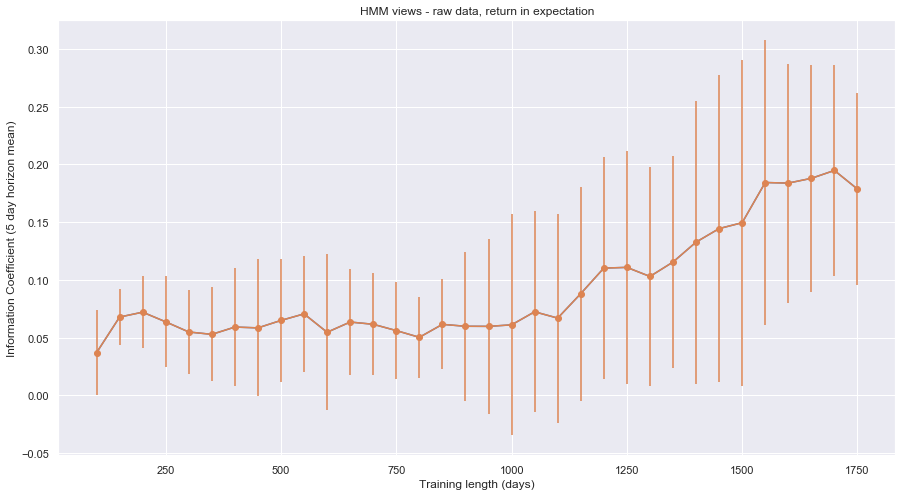

In [10]:
#%matplotlib
# Plot the IC versus train length
plt.figure(figsize=(15,8))
sns.set()
data = e_raw[e_raw.loc[:, 'halflife'] == 65]
ax = sns.lineplot(x='train_len', y='ic_5d_mean', data=data)
ax.errorbar(data['train_len'], data['ic_5d_mean'], yerr=data['ic_5d_std'], fmt='-o')
ax.set_title('HMM views - raw data, return in expectation')
ax.set(xlabel='Training length (days)', ylabel='Information Coefficient (5 day horizon mean)')
#plt.show()

### 2.2 Frontier: expected return, exponential decay

In [36]:
# library
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
e_exp = data[(data.loc[:, 'hmm_mode'] == 'e') & (data.loc[:, 'preprocess'] == 'exponential')]

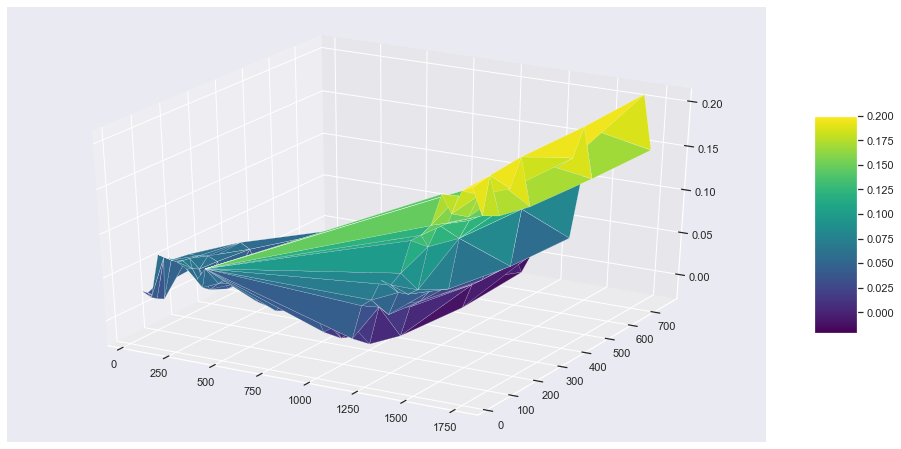

In [38]:
# Make the plot
fig = plt.figure(figsize=(17,8))
ax = fig.gca(projection='3d')

# Add a color bar which maps values to colors
surf=ax.plot_trisurf(e_exp['train_len'], e_exp['halflife'], e_exp['ic_5d_mean'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.view_init(0,45)
plt.show()

### 2.3 Frontier: threshold regime return, no preprocessing

In [26]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
t_raw = data[(data.loc[:, 'hmm_mode'] == 't') & (pd.isna(data.loc[:, 'preprocess']))]
t_raw[t_raw.loc[:, 'halflife'] == 65]

,hmm_mode,preprocess,train_len,halflife,ic_5d_mean,ic_5d_std
149,t,NaN,100,65,0.065804,0.058993
150,t,NaN,150,65,0.076300,0.025619
151,t,NaN,200,65,0.069532,0.043369
152,t,NaN,250,65,0.058233,0.035810
153,t,NaN,300,65,0.049980,0.033530
154,t,NaN,350,65,0.059070,0.048620
155,t,NaN,400,65,0.058627,0.058583
156,t,NaN,450,65,0.053748,0.060151
157,t,NaN,500,65,0.061070,0.064560
158,t,NaN,550,65,0.066485,0.049016


[Text(0, 0.5, 'Information Coefficient (5 day horizon mean)'),
 Text(0.5, 0, 'Training length (days)')]

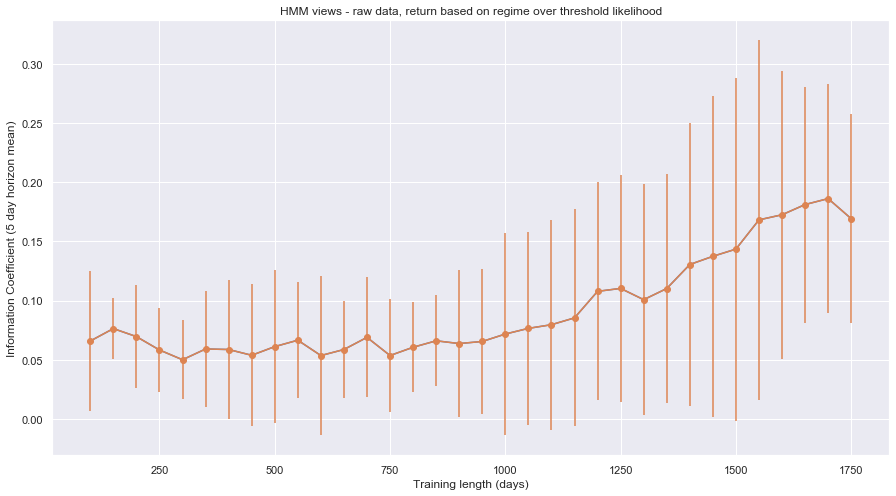

In [28]:
#%matplotlib
# Plot the IC versus train length
plt.figure(figsize=(15,8))
sns.set()
data = t_raw[t_raw.loc[:, 'halflife'] == 65]
ax = sns.lineplot(x='train_len', y='ic_5d_mean', data=data)
ax.errorbar(data['train_len'], data['ic_5d_mean'], yerr=data['ic_5d_std'], fmt='-o')
ax.set_title('HMM views - raw data, return based on regime over threshold likelihood')
ax.set(xlabel='Training length (days)', ylabel='Information Coefficient (5 day horizon mean)')


### 2.4 Frontier: threshold regime return, exponential decay

In [39]:
# Get the data
data = pd.read_csv(ss.cfg['data_dir'] + 'hmm_ic.csv')
t_exp = data[(data.loc[:, 'hmm_mode'] == 'e') & (data.loc[:, 'preprocess'] == 'exponential')]

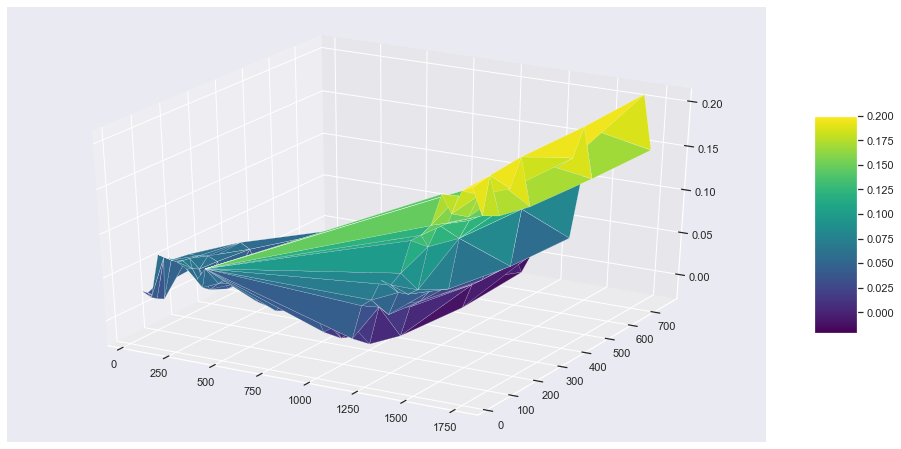

In [40]:
# Make the plot
fig = plt.figure(figsize=(17,8))
ax = fig.gca(projection='3d')

# Add a color bar which maps values to colors
surf=ax.plot_trisurf(t_exp['train_len'], t_exp['halflife'], t_exp['ic_5d_mean'], cmap=plt.cm.viridis, linewidth=0.2)
fig.colorbar(surf, shrink=0.5, aspect=5)
#ax.view_init(0,45)
plt.show()